# Precomputing the embeddings

[COCO 2015 Image Captioning Task](https://cocodataset.org/#captions-2015)

[coco-caption/annotations/](https://github.com/tylin/coco-caption/tree/master/annotations)

[CLIP Colab Notebook](https://colab.research.google.com/github/openai/clip/blob/master/notebooks/Interacting_with_CLIP.ipynb)

[Reference for working with the COCO Captions dataset](https://github.com/vidyasrimani/ComputerVision_ImageCaptioning)

[CIFAR100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html)

Prepare the COCO Captions dataset

In [ ]:
! wget http://images.cocodataset.org/zips/val2014.zip
! wget https://raw.githubusercontent.com/tylin/coco-caption/master/annotations/captions_val2014.json
! unzip -q val2014.zip

--2022-05-26 14:15:41--  http://images.cocodataset.org/zips/val2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.198.33
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.198.33|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6645013297 (6.2G) [application/zip]
Saving to: ‘val2014.zip’

val2014.zip         100%[===================>]   6.19G  43.8MB/s    in 2m 22s  

2022-05-26 14:18:03 (44.7 MB/s) - ‘val2014.zip’ saved [6645013297/6645013297]

--2022-05-26 14:18:03--  https://raw.githubusercontent.com/tylin/coco-caption/master/annotations/captions_val2014.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29707814 (28M) [text/plain]
Saving to: ‘captions_val2014.json’

captions_val2014.js

In [ ]:
import torch
from torchvision.datasets import CocoDetection, CIFAR100
import torchvision.transforms as transforms
import pickle as pkl

In [ ]:
class UniformCocoCaptions(CocoDetection):
    """`Same as torchvision.datasets.CocoCaptions, but 
    always outputs exactly 5 captions (for batch formation)
    """

    def _load_target(self, id: int):
        return [ann["caption"] for ann in super()._load_target(id)[:5]]

Prepare CIFAR-100 dataset

In [ ]:
CIFAR100(root='datasets/cifar100', train=True, download=True)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting datasets/cifar100/cifar-100-python.tar.gz to datasets/cifar100


Dataset CIFAR100
    Number of datapoints: 50000
    Root location: datasets/cifar100
    Split: Train

In [ ]:
with open('datasets/cifar100/cifar-100-python/meta', 'rb') as f:
    class_names = pkl.load(f)['fine_label_names']
assert len(class_names) == 100
class_names[:3]

['apple', 'aquarium_fish', 'baby']

In [ ]:
image, label = CIFAR100(root='datasets/cifar100', train=True, download=False)[0]

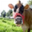

In [ ]:
image

In [ ]:
class_names[label]

'cattle'

Prepare the CLIP model

In [ ]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-f9mqrnt5
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-f9mqrnt5
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369387 sha256=78eaaee1cd5f41487ed6f1e53956d12e1321efd15b17b71b2e9595ca9933916d
  Stored in directory: /tmp/pip-ephem-wheel-cache-s_zoyqxf/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


In [ ]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

Compute the embeddings

In [ ]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data._utils.collate import default_collate
from pathlib import Path
from tqdm import tqdm
from itertools import chain
import gc

In [ ]:
@torch.no_grad()
def compute_clip_coco_embeds(clip_model_name, coco_images_dir, coco_captions_file,
                             batch_size=64, save_root=None,
                             image_embeds_filename_prefix=None,
                             text_embeds_filename_prefix=None,
                             save_all_texts=False):
    if not image_embeds_filename_prefix:
        image_embeds_filename_prefix = ''
    else:
        image_embeds_filename_prefix += '_'
    if not text_embeds_filename_prefix:
        text_embeds_filename_prefix = ''
    else:
        text_embeds_filename_prefix += '_'
    image_save_dir = Path(save_root) / 'image'
    image_save_dir.mkdir(parents=True, exist_ok=True)
    text_save_dir = Path(save_root) / 'text'
    text_save_dir.mkdir(parents=True, exist_ok=True)    

    device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
    print(f'Using {device}')
    print('Loading CLIP')
    model, preprocess = clip.load(clip_model_name)
    model.to(device)
    print('Done')
    dataset = UniformCocoCaptions(root='/content/val2014',
                    annFile='captions_val2014.json',
                    transform=preprocess)
    print('COCO dataset:\n', dataset)
    dataloader = DataLoader(dataset, batch_size=batch_size, 
                            pin_memory=torch.cuda.is_available(), num_workers=2)

    all_image_embeddings = []
    all_text_embeddings = []
    print('Computing embeddings')
    for batch in tqdm(dataloader):
        images, texts = batch
        image_input = images.to(device)
        # texsts have 5 tuples with batch_size texts
        # rearrange them, so that the 5 texts are next to each other
        texts = list(chain(*list(zip(*texts))))
        text_tokens = clip.tokenize(texts).to(device)
        image_features = model.encode_image(image_input).float()
        text_features = model.encode_text(text_tokens).float()
        all_image_embeddings.append(image_features)
        all_text_embeddings.append(text_features)
    embed_dim = all_image_embeddings.shape[-1]
    all_image_embeddings = torch.cat(all_image_embeddings, dim=0)
    all_text_embeddings = torch.cat(all_text_embeddings, dim=0).reshape(-1, 5, embed_dim)

    image_embeds_filename = image_embeds_filename_prefix + \
                            f'CLIP_{clip_model_name.replace("/", "-")}.pt'
    torch.save(all_image_embeddings, image_save_dir / image_embeds_filename)
    for i in range(5 if save_all_texts else 1):
        text_embeds_filename = text_embeds_filename_prefix + \
                               f'CLIP_{clip_model_name.replace("/", "-")}_{i}.pt'
        torch.save(torch.clone(all_text_embeddings[:, i, :]), text_save_dir / text_embeds_filename)
    print('Done')
    print(f'Image embeddings: {all_image_embeddings.shape}')
    print(f'Text  embeddings: {all_text_embeddings.shape}')
    gc.collect()

@torch.no_grad()
def compute_clip_cifar_embeds(clip_model_name, dataset_root, train,
                              batch_size=256, save_root=None,
                              image_embeds_filename_prefix=None,
                              label_filename_prefix=None,
                              text_embeds_filename_prefix=None,
                              template='low-resolution photo of a {}'):
    if not image_embeds_filename_prefix:
        image_embeds_filename_prefix = ''
    else:
        image_embeds_filename_prefix += '_'
    if not label_filename_prefix:
        label_filename_prefix = ''
    else:
        label_filename_prefix += '_'
    if not text_embeds_filename_prefix:
        text_embeds_filename_prefix = ''
    else:
        text_embeds_filename_prefix += '_'
    image_save_dir = Path(save_root) / 'image'
    image_save_dir.mkdir(parents=True, exist_ok=True)
    label_save_dir = Path(save_root) / 'label'
    label_save_dir.mkdir(parents=True, exist_ok=True)
    text_save_dir = Path(save_root) / 'text'
    text_save_dir.mkdir(parents=True, exist_ok=True)    

    device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
    print(f'Using {device}')
    print('Loading CLIP')
    model, preprocess = clip.load(clip_model_name)
    model.to(device)
    print('Done')
    dataset = CIFAR100(dataset_root, train, transform=preprocess, download=False)
    print('CIFAR100 dataset:\n', dataset)
    dataloader = DataLoader(dataset, batch_size=batch_size, 
                            pin_memory=torch.cuda.is_available())#, num_workers=2)

    all_image_embeddings = []
    all_labels = []
    print('Computing embeddings')
    for batch in tqdm(dataloader):
        images, labels = batch
        image_input = images.to(device)
        image_features = model.encode_image(image_input).float()
        all_image_embeddings.append(image_features)
        all_labels.append(labels)
    all_image_embeddings = torch.cat(all_image_embeddings, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    image_embeds_filename = image_embeds_filename_prefix + \
                            f'CLIP_{clip_model_name.replace("/", "-")}.pt'
    label_filename = label_filename_prefix + \
                            f'CLIP_{clip_model_name.replace("/", "-")}.pt'
    torch.save(all_image_embeddings, image_save_dir / image_embeds_filename)
    torch.save(all_labels, label_save_dir / label_filename)
    with open('datasets/cifar100/cifar-100-python/meta', 'rb') as f:
        class_names = pkl.load(f)['fine_label_names']
    texts = [template.format(name) for name in class_names]
    text_tokens = clip.tokenize(texts).to(device)
    text_features = model.encode_text(text_tokens).float()
    text_embeds_filename = text_embeds_filename_prefix + \
                            f'CLIP_{clip_model_name.replace("/", "-")}.pt'
    torch.save(text_features, text_save_dir / text_embeds_filename)
    print('Done')
    print(f'Image embeddings: {all_image_embeddings.shape}')
    print(f'Labels: {all_labels.shape}')
    print(f'Text ({template.format("<class>")}) embeddings: {text_features.shape}')
    gc.collect()

In [ ]:
clip_models = [#'RN50',
               'RN101',
               #'RN50x4',
               #'RN50x16',
               #'RN50x64',
               'ViT-B/32',
               #'ViT-B/16',
               #'ViT-L/14',
               #'ViT-L/14@336px']
              ]            

In [ ]:
for clip_model_name in clip_models:
    print(clip_model_name)
    clip.load(clip_model_name)

In [ ]:
clip_model_name = 'RN50'
coco_images_dir = 'val2014'
coco_captions_file = 'captions_val2014.json'
save_root = 'embeddings/coco_val2014'
image_embeds_filename_prefix = None
text_embeds_filename_prefix = None
batch_size = 256
# for clip_model_name in clip_models:
compute_clip_coco_embeds(clip_model_name, coco_images_dir, coco_captions_file,
                            batch_size, save_root,
                            image_embeds_filename_prefix,
                            text_embeds_filename_prefix)

In [ ]:
# clip_model_name = 'ViT-B/32'
dataset_root = 'datasets/cifar100'
train = True
save_root = f'embeddings/CIFAR100{"train" if train else "test"}'
template = 'low-resolution photo of a {}'
image_embeds_filename_prefix = None
label_filename_prefix = None
text_embeds_filename_prefix = None
batch_size = 256
for clip_model_name in clip_models:
    compute_clip_cifar_embeds(clip_model_name, dataset_root, train,
                              batch_size, save_root,
                              image_embeds_filename_prefix,
                              label_filename_prefix,
                              text_embeds_filename_prefix)

In [ ]:
# clip_model_name = 'ViT-B/32'
train = False
save_root = f'embeddings/CIFAR100{"train" if train else "test"}'
for clip_model_name in clip_models:
    compute_clip_cifar_embeds(clip_model_name, dataset_root, train,
                              batch_size, save_root,
                              image_embeds_filename_prefix,
                              label_filename_prefix,
                              text_embeds_filename_prefix)

In [ ]:
! du -sh /content/embeddings

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! cp -R /content/embeddings /content/drive/MyDrive/DL_NLP_project/embeddings

In [ ]:
! zip -r embeddings.zip embeddings/